# Load Imports

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import requests
import zipfile
import io


# Load, Preprocess, Split - Dataset

In [ ]:

def load_data():
  # Set the URL and file name for the dataset
  url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
  filename = 'movielens.zip'

  # Download the dataset
  response = requests.get(url)

  # Extract the dataset
  with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
      zip_ref.extractall()

  # Load the ratings.csv and movies.csv files into pandas dataframes
  ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, names=['userId', 'movieId', 'rating', 'timestamp'], engine='python')
  movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, names=['movieId', 'title', 'genres'], engine='python', encoding='latin-1')

  return ratings, movies




In [ ]:
ratings, movies = load_data()

# Print the first few rows of each dataframe
print('Ratings dataframe:')
print(ratings.head())
print('\nMovies dataframe:')
print(movies.head())

Ratings dataframe:
   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Movies dataframe:
   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy


In [ ]:
# Encode the user and movie IDs
user_encoder = {u: i for i, u in enumerate(ratings['userId'].unique())}
movie_encoder = {m: i for i, m in enumerate(ratings['movieId'].unique())}
ratings['userId'] = ratings['userId'].apply(lambda x: user_encoder[x])
ratings['movieId'] = ratings['movieId'].apply(lambda x: movie_encoder[x])


# Map the movie IDs to their titles
movie_titles = {}
for movie_id in movie_encoder:
    title = movies.loc[movies['movieId'] == movie_id]['title'].values[0]
    movie_titles[movie_encoder[movie_id]] = title

# Split the data into training and validation sets
train, val = train_test_split(ratings, test_size=0.4)




In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


# Movie Lens Dataset class

In [ ]:
# Define the Movielens dataset
class MovielensDataset(Dataset):
    def __init__(self, data):
        self.user_ids = data['userId'].values
        self.movie_ids = data['movieId'].values
        self.ratings = data['rating'].values
        
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        return (self.user_ids[idx], self.movie_ids[idx]), self.ratings[idx]


# Matrix Factorization Model

In [ ]:
# Define the matrix factorization model
class MatrixFactorizationModel(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(num_users, embedding_dim)
        self.movie_embeddings = torch.nn.Embedding(num_movies, embedding_dim)
        self.bias_user = torch.nn.Embedding(num_users, 1)
        self.bias_movie = torch.nn.Embedding(num_movies, 1)
        self.global_bias = torch.nn.Parameter(torch.tensor(ratings['rating'].mean()))
        
    def forward(self, user_ids, movie_ids):
        user_embeds = self.user_embeddings(user_ids)
        movie_embeds = self.movie_embeddings(movie_ids)
        user_bias = self.bias_user(user_ids)
        movie_bias = self.bias_movie(movie_ids)
        dot_product = torch.sum(user_embeds * movie_embeds, dim = 1)
        output = dot_product + user_bias.squeeze() + movie_bias.squeeze() + self.global_bias
        return output

# Define the training loop
def train_model(model, train_loader,loss_list, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (inputs, ratings) in enumerate(train_loader):
            user_ids = inputs[0]
            movie_ids = inputs[1]
            ratings = ratings.float()
            outputs = model(user_ids, movie_ids)
            loss = criterion(outputs, ratings)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        loss_list.append(train_loss)
        print('Epoch: {} Train Loss: {:.4f}'.format(epoch+1, train_loss))

# Create Data Loader for train and validation set

In [ ]:
# Instantiate the dataset and data loaders
train_dataset = MovielensDataset(train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = MovielensDataset(val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Build & Train Model

In [ ]:
# Instantiate the model and define the loss and optimizer
model = MatrixFactorizationModel(num_users=len(ratings['userId'].unique()), 
                                 num_movies=len(ratings['movieId'].unique()), 
                                 embedding_dim=64)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_list = []

# Train the model
train_model(model, train_loader, loss_list, criterion, optimizer, num_epochs=15)


Epoch: 1 Train Loss: 44.1944
Epoch: 2 Train Loss: 13.1056
Epoch: 3 Train Loss: 4.4026
Epoch: 4 Train Loss: 2.0001
Epoch: 5 Train Loss: 1.2203
Epoch: 6 Train Loss: 0.9171
Epoch: 7 Train Loss: 0.7772
Epoch: 8 Train Loss: 0.6976
Epoch: 9 Train Loss: 0.6411
Epoch: 10 Train Loss: 0.5987
Epoch: 11 Train Loss: 0.5620
Epoch: 12 Train Loss: 0.5315
Epoch: 13 Train Loss: 0.5048
Epoch: 14 Train Loss: 0.4817
Epoch: 15 Train Loss: 0.4611


# Training loss Plot

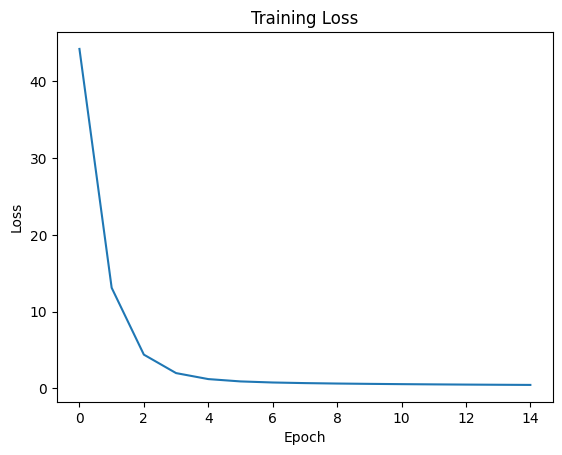

In [ ]:
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(loss_list)

# Set axis labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')

# Show the plot
plt.show()

# Compute MSE, RMSE

In [ ]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(val_loader): 
        model_output = model(batched_data[0][0], 
                       batched_data[0][1])
        
        model_output_list.append(model_output.sum().item() / len(batched_data[0][0]) )

        target_rating = batched_data[1]
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data[0][0]))

        # print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rmse = mean_squared_error(target_rating_list, model_output_list, squared=False)
mse = mean_squared_error(target_rating_list, model_output_list, squared=True)
print(f"mse: {mse}")
print(f"rmse: {rmse}")

mse: 0.0757224190643579
rmse: 0.27517706856560176


# Evaluation Metrics

In [ ]:
def evaluate_model(model, val_loader, threshold):
    """Compute recall, precision, f_score, and ndcg of the model on the validation set."""
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    ndcg = 0
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for batch in val_loader:
            # Unpack the batch elements
            user_ids = batch[0][0]
            movie_ids = batch[0][1]
            ratings = batch[1]

            # Predict the ratings for the validation set
            preds = model(user_ids, movie_ids).squeeze()
            
            # Compute the binary predictions using the threshold
            binary_preds = torch.where(torch.logical_and(preds >= threshold, preds <= 5), torch.ones_like(preds), torch.zeros_like(preds))
            
            binary_movie_rating = torch.where(ratings >= threshold, torch.ones_like(preds), torch.zeros_like(preds))
            # Compute the true positives, false positives, and false negatives
            true_positives += ((binary_preds == 1) & (binary_movie_rating == 1)).sum().item()
            false_positives += ((binary_preds == 1) & (binary_movie_rating == 0)).sum().item()
            false_negatives += ((binary_preds == 0) & (binary_movie_rating == 1)).sum().item()

            
            # Compute the NDCG score
            ndcg += ndcg_score(np.expand_dims(ratings, axis=0), np.expand_dims(preds, axis=0), k=10).item()
    
    # Compute the recall, precision, f_score, and ndcg
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)
    f_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0.0
    ndcg /= len(val_loader)
    
    return recall, precision, f_score, ndcg


# Compute Recall, Precision, F_score, Ndcg 

In [ ]:
recall, precision, f_score, ndcg = evaluate_model(model, val_loader, 3.5)
print(f"Recall:  {recall}, Precision: {precision}, F_score: {f_score}, Ndcg: {ndcg}")

Recall:  0.5784641032208768, Precision: 0.7038179551649094, F_score: 0.635013832725297, Ndcg: 0.8273042336595495


# Compute Recall@K, Precision@K



In [ ]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]

model.eval()
with torch.no_grad():
    for i, batched_data in enumerate(val_loader): 
        users = batched_data[0][0]
        movies = batched_data[0][1]
        ratings = batched_data[1]

        
        model_output = model(batched_data[0][0], batched_data[0][1])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item() 
            pred_rating = model_output[i].item()
            true_rating = ratings[i].item()
            
            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating, movie_id))            


Streaming output truncated to the last 5000 lines.
2618, 136, 4.499619483947754, 5
4445, 1607, 2.4525890350341797, 3
5973, 238, 4.496104717254639, 4
909, 733, 4.774290084838867, 4
6009, 381, 4.218744277954102, 4
4168, 698, 4.2033538818359375, 3
5981, 630, 3.436511993408203, 3
5162, 1852, 2.563279628753662, 4
4972, 1730, 3.919581890106201, 4
4460, 1027, 5.943838119506836, 4
283, 155, 4.259617805480957, 4
2765, 381, 3.3547472953796387, 2
1644, 1083, 4.642421245574951, 4
4343, 555, 2.5025830268859863, 4
475, 688, 4.048641204833984, 5
3425, 1234, 5.3551859855651855, 5
1819, 890, 3.3792219161987305, 1
2536, 1666, 3.19279146194458, 1
1748, 603, 2.476113796234131, 3
5989, 139, 3.7101988792419434, 3
623, 577, 1.6953493356704712, 2
1458, 50, 4.263272762298584, 2
4681, 3437, 3.3852882385253906, 4
2057, 3, 4.157371997833252, 3
3768, 1027, 4.794632911682129, 5
888, 256, 3.3546245098114014, 4
4226, 1536, 3.260388135910034, 1
1100, 48, 4.436152458190918, 3
2260, 498, 5.324808120727539, 5
4878, 314, 

In [ ]:

with torch.no_grad():
    precisions = dict()
    recalls = dict()
    recommended_movies = dict()
    k = 200

    threshold = 3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. 
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        top_k_movies = [movie_titles[movie_id] for (est, true_r, movie_id) in user_ratings[:k] if est >= threshold and est <= 5]

        # Add the recommended movies to the dictionary for this user
        recommended_movies[uid] = top_k_movies[:k]
 
        # 这里 get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r,_) in user_ratings)

        # 这里 get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _, _) in user_ratings[:k])

        # 这里 get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r, _) in user_ratings[:k]
        )

        # print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of   relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0



In [ ]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


NameError: ignored

# Recommend Movies to User

In [ ]:
recommended_movies

{3074: ['American Werewolf in London, An (1981)',
  'Alien (1979)',
  'Omen, The (1976)',
  'Spiral Staircase, The (1946)',
  'Rebecca (1940)',
  'Terms of Endearment (1983)',
  "Singin' in the Rain (1952)",
  'Take the Money and Run (1969)',
  'Terminator 2: Judgment Day (1991)',
  'Aliens (1986)',
  'Ever After: A Cinderella Story (1998)',
  'Jurassic Park (1993)',
  'Professional, The (a.k.a. Leon: The Professional) (1994)',
  'Strangers on a Train (1951)',
  'All About Eve (1950)',
  'E.T. the Extra-Terrestrial (1982)',
  'Rear Window (1954)',
  "One Flew Over the Cuckoo's Nest (1975)",
  'Almost Famous (2000)',
  'Willy Wonka and the Chocolate Factory (1971)',
  '400 Blows, The (Les Quatre cents coups) (1959)',
  'Sound of Music, The (1965)',
  'Silence of the Lambs, The (1991)',
  'Mary Poppins (1964)',
  'Aladdin (1992)',
  'Sling Blade (1996)',
  'Raging Bull (1980)',
  'Awakenings (1990)',
  'Shining, The (1980)',
  'Stand by Me (1986)',
  'Wizard of Oz, The (1939)',
  'Jaws (

In [ ]:
# Sample User
user_id = 478
recommended_movies[user_id]

NameError: ignored

In [ ]:
def recommend_unwatched_movies(model, user_encoder, movie_encoder, user_id, threshold, top_n=10):
    """Recommend top N movies to the given user that they have not yet watched."""
    
    # Get the list of all movies
    all_movies = np.array(list(movie_encoder.keys()))
    
    # Get the list of movies rated by the user
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    
    # Get the list of movies the user has not watched
    unwatched_movies = np.setdiff1d(all_movies, rated_movies)

    # Get the encoded user ID
    encoded_user_id = user_encoder[user_id]
  
    # Get the predicted ratings for the user and unwatched movies
    recommended_movie_id = []
    for movie_id in unwatched_movies:
        encoded_movie_id = movie_encoder[movie_id]
        predicted_rating = model(torch.LongTensor([encoded_user_id]), torch.LongTensor([encoded_movie_id])).item()
        if (predicted_rating >= threshold and predicted_rating <= 5.0):
            recommended_movie_id.append((predicted_rating, movie_id))
    
    # Sort the unwatched movies by predicted rating and recommend the top N
    recommended_movie_id.sort(key = lambda x : x[0], reverse=True)
    top_movies = [movie_titles[movie_encoder[movie_id]] for _, movie_id in recommended_movie_id[:top_n]]
    
    return top_movies


In [ ]:
# Load the Movielens dataset
ratings, movies = load_data()

user_encoder = {u: i for i, u in enumerate(ratings['userId'].unique())}
movie_encoder = {m: i for i, m in enumerate(ratings['movieId'].unique())}
ratings['userId'] = ratings['userId'].apply(lambda x: user_encoder[x])
ratings['movieId'] = ratings['movieId'].apply(lambda x: movie_encoder[x])


# Map the movie IDs to their titles
movie_titles = {}
for movie_id in movie_encoder:
    title = movies.loc[movies['movieId'] == movie_id]['title'].values[0]
    genres = movies.loc[movies['movieId'] == movie_id]['genres'].values[0]
    movie_titles[movie_encoder[movie_id]] = (title, genres)



In [ ]:
user_id = 478
print('User ID:', user_id, recommend_unwatched_movies(model, user_encoder, movie_encoder, user_id, 3.5))

User ID: 478 [('Buddy Holly Story, The (1978)', 'Drama'), ('Bicycle Thief, The (Ladri di biciclette) (1948)', 'Drama'), ('Mighty Peking Man (Hsing hsing wang) (1977)', 'Adventure|Sci-Fi'), ('Final Destination (2000)', 'Drama|Thriller'), ('Story of Us, The (1999)', 'Comedy|Drama'), ('Nightwatch (1997)', 'Horror|Thriller'), ('EDtv (1999)', 'Comedy'), ('Hearts and Minds (1996)', 'Drama'), ('Coma (1978)', 'Thriller'), ("Cookie's Fortune (1999)", 'Mystery')]
